In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Reading data file
df3 = pd.read_csv('data_prepared.csv')

In [3]:
df3 = df3.loc[df3['Security Type'] == 'Common Stock']

In [4]:
df3 = df3.dropna()

In [5]:
#Select appropriate features
features3 = ["Security Price", "Volume (90 Day Avg)", "Market Capitalization", "Dividend Yield", "Total Return (1 Yr Annualized)", "Beta (1 Year Annualized)", "Standard Deviation (1 Yr Annualized)", "S&P Global Market Intelligence Valuation", "S&P Global Market Intelligence Quality", "S&P Global Market Intelligence Growth Stability", "S&P Global Market Intelligence Financial Health", "Institutional Ownership", "Institutional Ownership (Last vs. Prior Qtr)"]

X3 = df3.copy()
y3 = X3.pop('Equity Summary Score')
X3 = X3.loc[:, features3]

# Standardize
X3_scaled = (X3 - X3.mean(axis=0)) / X3.std(axis=0)

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_s = PCA().fit(StandardScaler().fit_transform(X3)) 
pca_s.components_

array([[-3.82945293e-02, -1.06459373e-01, -9.93556736e-02,
         2.04309002e-01, -5.52529672e-02, -2.10848575e-01,
        -1.84345810e-01, -5.59222000e-01, -4.93120014e-01,
        -2.48923782e-01, -4.65112777e-01, -9.72633414e-02,
         1.02191622e-01],
       [ 7.82242861e-02, -1.97747063e-01, -1.75788512e-01,
        -4.33439610e-01, -2.81397526e-01,  5.21983071e-01,
         4.78283172e-01, -1.27739192e-01, -1.72179913e-01,
        -7.56572924e-02, -1.75876549e-01,  2.66303947e-01,
         4.54122661e-02],
       [ 3.36246343e-01,  5.13559863e-01,  5.99247148e-01,
        -6.25030957e-02,  1.30461704e-01,  2.19018140e-01,
         1.54610024e-01, -1.84206579e-01, -9.27376646e-02,
         1.85249008e-01, -2.07795344e-01, -2.26383614e-01,
         4.40928826e-03],
       [ 6.32863149e-01, -3.21623966e-01,  1.66448110e-01,
        -2.48884601e-01,  3.98851355e-02, -1.78550199e-01,
        -3.96651875e-01, -3.46370708e-02,  1.77353986e-01,
         2.39949629e-02, -1.40112653e

#### Part a

In [7]:
# plotting variance
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

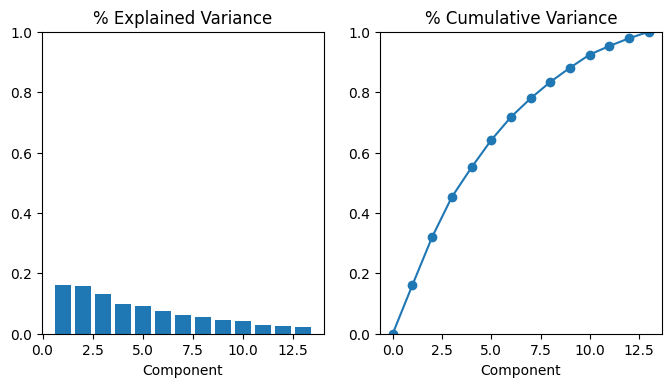

In [8]:
# Look at explained variance
plot_variance(pca_s);

#### Part b

In [9]:
# 10-Fold Cross Validation
def cross_validation (df, func):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits = 10, shuffle = True, random_state = 10)
    kf_rmse = []
    
    for train, test in kf.split(df):
        X_train = df.iloc[train].loc[:, df.columns != 'Equity Summary Score']
        X_train = X_train.squeeze()
        X_test = df.iloc[test].loc[:, df.columns != 'Equity Summary Score']
        y_train = df.iloc[train].loc[:,'Equity Summary Score']
        y_test = df.iloc[test].loc[:,'Equity Summary Score']
        
        reg = func.fit(X_train, y_train)
        y_hat = reg.predict(X_test)
        
        from sklearn.metrics import mean_squared_error
        kf_rmse.append(mean_squared_error(y_test, y_hat, squared=False))
        
    kf_RMSE = (1/10) * np.sum(kf_rmse)
        
    return (kf_RMSE)

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

mse3 = []

df_3 = pd.concat([X3_scaled, y3], axis = 1)

for i in range(1,14,1):
    reg = make_pipeline(PCA(n_components=i), LinearRegression()).fit(X3_scaled, y3)
    y_hat = reg.predict(X3_scaled)
    mse3.append(cross_validation(df_3,make_pipeline(PCA(n_components=i), LinearRegression())))

In [11]:
rmse_PCR = pd.DataFrame(zip(np.linspace(1,len(mse3),len(mse3)), mse3), columns = ['PC','rmse'])
rmse_PCR.loc[rmse_PCR['rmse'] == rmse_PCR['rmse'].min()]

,PC,rmse
11,12.0,2.159135


#### Part b1

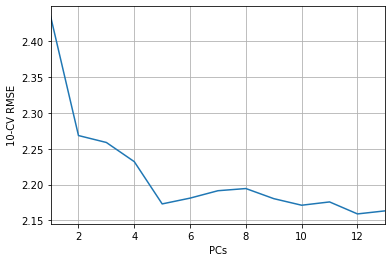

In [12]:
x = rmse_PCR['PC']
y = rmse_PCR['rmse']

plt.plot(x, y)
plt.xlim(1, 13) 
plt.ylabel('10-CV RMSE')
plt.xlabel('PCs')
plt.grid()
plt.show()

#### Part b2

In [13]:
#The optimal number of PCs to include in the PCR is 12 as it returned the lowest 10-CV RMSE
#However, looking at the cumulated % of variance explained plot, one may find it desirable to select the minimum
#number of PCs that can sufficiently explain the variance in the data (ex. 7 PCs explain 80% of the variance)

#### Part b3

In [14]:
# PCA
from sklearn.preprocessing import StandardScaler

pca_s2 = PCA(n_components = 12).fit(StandardScaler().fit_transform(X3))    
print('PC_s\n', pca_s2.components_)  # each row is a PC

PC_s
 [[-3.82945293e-02 -1.06459373e-01 -9.93556736e-02  2.04309002e-01
  -5.52529672e-02 -2.10848575e-01 -1.84345810e-01 -5.59222000e-01
  -4.93120014e-01 -2.48923782e-01 -4.65112777e-01 -9.72633414e-02
   1.02191622e-01]
 [ 7.82242861e-02 -1.97747063e-01 -1.75788512e-01 -4.33439610e-01
  -2.81397526e-01  5.21983071e-01  4.78283172e-01 -1.27739192e-01
  -1.72179913e-01 -7.56572924e-02 -1.75876549e-01  2.66303947e-01
   4.54122661e-02]
 [ 3.36246343e-01  5.13559863e-01  5.99247148e-01 -6.25030957e-02
   1.30461704e-01  2.19018140e-01  1.54610024e-01 -1.84206579e-01
  -9.27376646e-02  1.85249008e-01 -2.07795344e-01 -2.26383614e-01
   4.40928826e-03]
 [ 6.32863149e-01 -3.21623966e-01  1.66448110e-01 -2.48884601e-01
   3.98851355e-02 -1.78550199e-01 -3.96651875e-01 -3.46370708e-02
   1.77353986e-01  2.39949629e-02 -1.40112653e-01  4.02201056e-01
  -3.10300993e-02]
 [-1.01316731e-01 -1.73654112e-01 -2.57122810e-01 -2.32887417e-02
   6.28997982e-01 -6.98235245e-03  1.55944217e-01 -1.5304518